# Imports

In [2]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from src.data.tiny_imagenet_dataset import SmallImageNetTrainDataset

# Data

In [27]:
transform = transforms.Compose([
        # transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"/Users/egorprokopov/Documents/ITMO/BachelorThesis/data/full_imagenet/train",
        classes_names_path=r"/Users/egorprokopov/Documents/ITMO/BachelorThesis/data/full_imagenet/classes_names.txt",
        transform=transform
)

In [28]:
sample = dataset[1000000]
image = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

In [29]:
image.shape, label

(torch.Size([3, 375, 500]), 780)

In [13]:
# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# image, label = train_dataset[0]
# label

6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8888357..2.6324956].


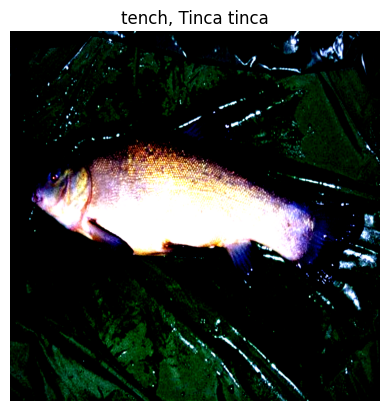

In [4]:
# plt.title(f"{dataset.classes_names[image_tag]}")
# plt.axis('off')
# plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)

# SVD

In [5]:
image.shape

torch.Size([3, 1024, 1024])

In [6]:
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 1024, 1024])

In [7]:
from src.tokenizers.svd_tokenizer import SVDSquareTokenizer

In [8]:
img_batch = torch.cat([image] * 32, dim=0)

In [9]:
tokenizer = SVDSquareTokenizer(image_size=1024, embedding_dim=768, dispersion=0.999, full_matrices=False)

In [10]:
approx_U, approx_S, approx_V, rank = tokenizer.get_approx_svd(image[0])

In [11]:
rank

213

In [12]:
reconstructed_image = tokenizer.reconstruct_image(approx_U, approx_S, approx_V)
reconstructed_image.shape

torch.Size([3, 1024, 1024])

In [13]:
# rank = 50
# 
# approx_image_channels = []
# for image_channel in image:
#     U, S, Vh = torch.linalg.svd(image_channel)
#     approx_image_channel = (U[:, :rank] @ torch.diag(S[:rank]) @ Vh[:rank, :])
#     approx_image_channels.append(approx_image_channel)
#     
# approx_image = torch.stack(approx_image_channels)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8888357..2.6324956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8995799..2.6837163].


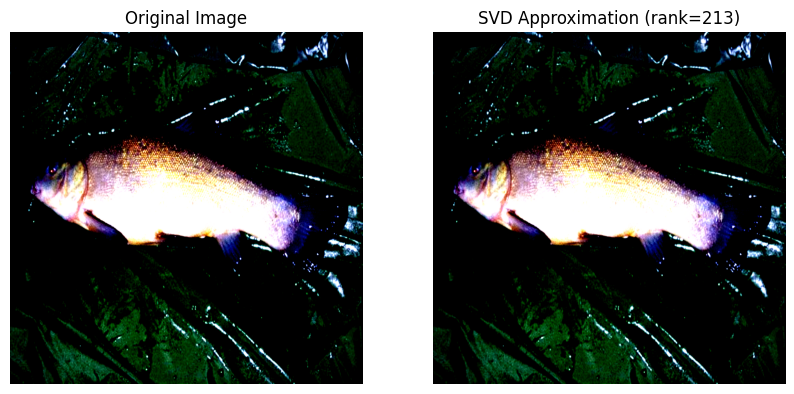

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image[0].permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[1].set_title(f"SVD Approximation (rank={rank})")
axes[1].axis("off")

plt.show()

## Tokenization

In [15]:
img_batch.shape

torch.Size([32, 3, 1024, 1024])

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
tokenizer = tokenizer.to(device)
img_batch = img_batch.to(device)

In [18]:
embedding = tokenizer(img_batch)

In [19]:
embedding.shape

torch.Size([32, 640, 768])

# SVD dispersion

In [ ]:
U, S, Vh = torch.linalg.svd(image, full_matrices=True)
Vh = Vh.mH

## Linear

In [ ]:
S_sum = S.sum(dim=0, keepdim=True)

S_cumsum = torch.cumsum(S_sum, dim=1)
total_sum = S_sum.sum()

S_cumsum_norm = S_cumsum / total_sum

In [ ]:
S_cumsum_norm_lin = S_cumsum_norm.squeeze().numpy()

## Quadratic

In [ ]:
S_squared = torch.square(S)
S_squared = S_squared.sum(dim=0, keepdim=True)

S_cumsum = torch.cumsum(S_squared, dim=1)
total_sum = S_squared.sum()

S_cumsum_norm = S_cumsum / total_sum

In [ ]:
S_cumsum_norm_quad = S_cumsum_norm.squeeze().numpy()

In [ ]:
plt.plot(S_cumsum_norm_lin)
plt.plot(S_cumsum_norm_quad)